# Preliminary Exploration

This is a preliminary exploration into the dataset for the 2017 Yelp Dataset Challenge (https://www.yelp.com/dataset_challenge). Yelp asks its participants use the dataset of local business reviews, business attributes, check-ins, and tips from various cities around the world to help Yelp understand cultural tends in consumer preferences. 

The goal of this exploration is to analyze initial variables found and determine an action plan for future analysis. Below I will clean up the data into a readable format and then investigate my initial findings and intuitions in order to determine what 
variables are most significant for analysis. I will use these to formulate next steps in further, more in-depth analysis. 

There are three parts to my initial exploration:

Section 1: **Data Wrangling** - Key Question: How can I extract potentially useful information from the dataset?

Section 2: **Data Analysis** - Key Question: What variables are potentially significant and in need of further analysis? 

Section 3: **Conclusion** - Key Question: What have we learned, and what further steps need to be taken? 



## Section 1 - Data Wrangling

In this section, I will clean up and format the data in a way to facilitate analysis. First, I import all the data and create a manageable sample set. Then I will introduce sentiment analysis into the review data for further analysis, and finally I will provide a means to categorize data by categories. 

In [1]:
# Imports
import pandas as pd
import json
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# Alpha will be 0.05 for all tests I will conduct. 
alpha = 0.05
# threshhold_n is the size required for a group to find the results significant. Given the large size of the population, this will be 200. For specific tests later, I will exclude certain groups that have samples smaller than 200 as being too small to provide meaningful data
threshhold_n = 100 

In [2]:
# Because this file does not use checkin_full, tip_full, and user_full in its analysis, so to save data and efficiency, these files are not imported. The import statements are kept as comments for future potential use if that they are needed in later. 

business_full = pd.DataFrame.from_csv('data\yelp_academic_dataset_business.csv', index_col=None)
#checkin_full = pd.DataFrame.from_csv('data\yelp_academic_dataset_checkin.csv', index_col=None)
review_full = pd.DataFrame.from_csv('data\yelp_academic_dataset_review.csv', index_col=None)
#tip_full = pd.DataFrame.from_csv('data\yelp_academic_dataset_tip.csv', index_col=None)
#user_full = pd.DataFrame.from_csv('data\yelp_academic_dataset_user.csv', index_col=None)

In the cell below, I create a sample of 6000 random businesses. This sample is subset of the original that I can conduct my tests below. review is then stores all reviews for the sampled businesses. 

In [3]:
size = 6000
business = business_full.sample(n = size)
review = review_full[review_full.business_id.isin(business.business_id) == True]

### Sentiment Analysis

I will be using TextBlob's sentiment analysis to measure how positive or negative a review is. TextBlob.sentiment provides two metrics: polarity and subjectivity. Polarity determines how positive or negative the sentiment on a [-1, 1] scale. Subjectivity measures the us subjective vs factual the language on a [0, 1] scale. 

Polarity provides an excellent continuous, quantitative variable to express a user's favorability. As such it will be the primary metric I will use to analyze how much a user likes or dislikes a particular business. There are several other quantiative variables that also reflect favorability (such as with the number of stars they rate a business) and interrelated variables like subjectivity. In Section 2, I will discuss in more detail why I intend to use polarity and how it connects with similar variables. In this section, I will simply conduct sentiment analysis on the data and clean it up for further analysis.  

In the cell below, I add two columns to the review DataFrame for the polarity and subjectivity of each user's review. This will enable me to analyze polarity and subjectivity in the rest of my exploration. 

In [4]:
''' 
TextBlob.sentiment returns the polarity and subjectivity of the given text. 
To save time running, this conducts the sentiment function on the review as a new column and then stores the subjectivity and polarity as separate columns. It the deletes the now, unneeded sentiment column from the DataFrame. 
'''

sentiment = lambda x: TextBlob(str(x)).sentiment
review['sentiment'] = review['text']

review['sentiment'] = review['sentiment'].apply(sentiment)
polarity = lambda x: x[0]
subjectivity = lambda x: x[1]
review['polarity'] = review['sentiment']
review['polarity'] = review['sentiment'].apply(polarity)
review['subjectivity'] = review['sentiment']
review['subjectivity'] = review['sentiment'].apply(subjectivity)

review = review.drop('sentiment', axis=1) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

### Business Categories

The businesss DataFrame provides a column for business categories, in which it lists the business category for a particular business. This is extremely useful information but requires a bit of unpacking. It does not enable me to quickly group all businesses of a certain category or a comprehensive list of all possible business categories. 

The cell below creates a new DataFramee, called categories, which stores each businesses' categories. Each column is one business category with a 1 value if that business is in that category and 0 if it is not. I also created a master list of all categories for future reference. 

In [5]:
# Creates a new DataFrame, called categories, which stores each businessses' categories
categories = business.categories.str.replace('"', "'").str.replace("'", '').str.strip('[]').str.get_dummies(", ")
categories.insert(0, 'business_id', business['business_id'])
categories.insert(1, 'name', business['name'])

# categories_master_list is the list of all potential business categories. 
categories_master_list = categories.columns[2:]

categories.head()

,business_id,name,3D Printing,Accessories,Accountants,Active Life,Acupuncture,Adult,Adult Education,Adult Entertainment,...,Windshield Installation & Repair,Wine & Spirits,Wine Bars,Wine Tours,Wineries,Womens Clothing,Wraps,Yelp Events,Yoga,Zoos
62867,ObA-QNMqnv9X9g06zoDP3Q,Powter Puff Boutique,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
91316,BBzx1h2BDaO2EFi6V1jJew,Walmart,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105643,uX2t1KSUlDaGbGmbxdFxpg,Harris Limo,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133564,5AL3DYoi5rQ7QJLlQYmFNw,My Car Guy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103394,oLbHJ_qJh78Kw4fhUw1HGg,Mandarin Express,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Section 2 - Data Analysis

In this section, I will analyze potentially significant variables. The goal is to determine which variables may be important to analyze for results later. I will analyze four potentially significant variables: 

1) Sentiment polarity 

2) Business category

3) Location

4) Time of year. 

For the first variable, I will demonstrate potential relationships between polarity and other similar variables, explain why I think polarity is the best metric to express the users' stated feeling about a business, and discuss how to combine it with other variables in my analysis.

Then I will survey location and time of year to determine how likely they are to influence favorabiity results. My findings are that location likely influences polarity but time of year likely does not. Future analysis will be needed to better understand how location is an influence.

## Sentiment Polarity

TextBlob's sentiment polarity metric is intended to measure how positive or negative a text is. It rates each text on a scale from -1 (completely negative) to 1 (completely positive). In Section 1, I established the polarity of each review. I will use polarity as the primary metric to analyze a user's favorability towards a business. Star rating (a choice to give a business between 1 to 5 stars) is the other potential metric available in this data. There are three initial reasons I think polarity is the best metric: 

1) Polarity analyzes the users' stated opinions in the review instead of simply indicating their stated opinions. Thus, it can better analyze the positive and negative aspects of a complex review. 

2) Polarity is quantitative and continuous allowing for richer analysis. 

3) The categorical nature of a 5-scale star rating creates ambiguity and does not allow as rich an analysis. 

More details on these points are provided in the "Polarity vs Star Rating" Section. 

### Polarity vs Subjectivity 

First, I wanted to analyze whether there are connections between polarity (how favorable a user's opinion was reflected in a review) vs subjectivity (how opinion-oriented or factual was there language style). I wanted to determine whether there is a connection between favorability and the style of language used and to assess whether I could consider polarity and subjectivity as indepedent variables. 

I first created a scatter plot of the two to analyze any connections between polarity and subjectivity. Then I conducted a statistical test to test for indepedence between them. 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


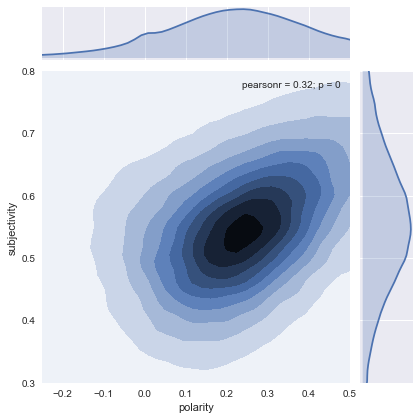

Null Hypothesis: Polarity and subjectivity of reviews are independent.
Alternative Hypothesis: Polarity and subjectivity are correlated.
 
Slope: 0.193705421904
Intercept: 0.510847603302
p: 0.0
Correlation Coefficient: 0.319099287006
Standard Error: 0.00136960582523
 
Reject the null


In [6]:
# Creates a scatter plot of polarity and subjectivity
sns.jointplot(y="subjectivity", x="polarity", data=review, kind="kde",  fit_reg = True, xlim={-0.25, 0.5}, ylim = {0.3, 0.8})
sns.plt.show()

# Conducts a hypothesis test to determine likeliness or unlikeliness of independence between polarity and subjectivity. 
# Creates a regression test on polarity and subjectivity. This will calculate three things of significance for this project: linear regression equation, probability of a relationship (value), and correlation coefficient. 
print("Null Hypothesis: Polarity and subjectivity of reviews are independent.")
print("Alternative Hypothesis: Polarity and subjectivity are correlated.")
print(" ")

slope, intercept, r_value, p_value, std_err = stats.linregress(review.polarity, review.subjectivity)
slope, intercept, r_value, p_value, std_err

print("Slope: " + str(slope))
print("Intercept: " + str(intercept))
print("p: " + str(p_value))
print("Correlation Coefficient: " + str(r_value))
print("Standard Error: " + str(std_err))
print(" ")

if(p_value < alpha): 
    print("Reject the null")
else: 
    print("Fail to reject the null")

In conclusion, they are not independent of each other. This may not seem surprising considering either the fact that one's favorability infuences the style of language use and the connections in TextBlob's algorithm for calculating both. 

### Polarity vs Star Rating

Here I compare polarity with the star rating. 

For the star rating, users rated the business between 1 to 5 stars. I do not intend to use star rating as a primary metric for analyzing user favorability. As a categorical variable based on stated opinions, its rating system creates ambiguity. I would prefer a scale with positive and negative values to reflect a favorable and unfavorable consumer opinion respectively. Currently the 1 to 5 scale does not allow that. Bad reviews are simply less positive than good reviews. That could be easily changed by altering the scale by subtracting by 3: 1 star goes to -2, 2 stars to -1, 3 stars to 0, 4 stars to 1, and 5 stars to 2. 


Presumably, a 4 or 5 star rating is intended to reflect a positive experience from the user and 1 or 2 stars a negative experience as implied in the modified scale. Would every user have this system in mind when they relate, though? Does a rating of 3 always reflect a truly neutral view for all users? I would suspect the answer to be no: different users would have different internal scales and meanings for each number of stars. 

Using the star rating to measure favorability would create too much ambiguity in the analysis based on these issues. At the same time, its discrete, categorical nature, despite being numerical, provide less flexibility in analysis than the continuous polarity. 

Below, I determine whether there is a statistical relationship between polarity and star rating. I would expect there to be. Even if star rating is not the best metric for favorability, it certainly reflects favorability pretty accurately. Establishing the statistical the connection between polarity and star rating helps ensure that polarity is an accurate metric for favorability. 

I created a scatter plot for polarity and star rating to show the general relationship. I then found the line of best fit and conducted a correlation test to determine whether they are correlated.

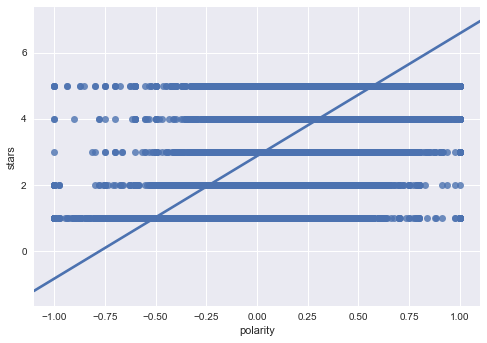

Null Hypothesis: Polarity and star rating are independent.
Alternative Hypothesis: Polarity and star rating are correlated.
 
Slope: 3.71696553588
Intercept: 2.86536189418
p: 0.0
Correlation Coefficient: 0.592678164721
Standard Error: 0.0120254539589
 
Reject the null


In [7]:
sns.regplot(y="stars", x="polarity", data=review, fit_reg = True)
sns.plt.show()

print("Null Hypothesis: Polarity and star rating are independent.")
print("Alternative Hypothesis: Polarity and star rating are correlated.")
print(" ")

slope, intercept, r_value, p_value, std_err = stats.linregress(review.polarity, review.stars)
slope, intercept, r_value, p_value, std_err

print("Slope: " + str(slope))
print("Intercept: " + str(intercept))
print("p: " + str(p_value))
print("Correlation Coefficient: " + str(r_value))
print("Standard Error: " + str(std_err))
print(" ")

if(p_value < alpha): 
    print("Reject the null")
else: 
    print("Fail to reject the null")

This is an extremely small p-value, leading to the conclusion that star rating and polarity are pretty connected. This helps confirm that both accurately represent user favorability. As described above, I prefer polarity as a metric for favorability, and this helps demonstrates the accuracy of using polarity. 

Further, I wanted to analyze the each star rating individually with polarity. As discussed above, I am skeptical of variations meanings on different star values for each user. For example, one could think that a rating of 3, being in the middle of the 1 through 5 scale, would mean a neutral, not favorable but not disfavorable impression by the user. Many people could think of vastly different scalings, however, with different intended meanings for a 3 star review. 

Below, I calculated the mean and standard deviation of polarity for each star rating value. That way, I can know whether star rating can accurately measure favorability. I would expect a 1-star rating to have a mean polarity close to -1 and a 5-star rating a mean polarity close to 1, indicating a strong negative and positive sentiment respectively. I would expect a 2-star rating and a 4-star rating to be slightly more moderate around -0.5 and 0.5 respectively. Finally, I would expect a 3-star rating to have a mean around 0 to reflect a neutral preference. 

In [8]:
# Finds the mean and standard deviation of each star rating 
mean_polarity_by_stars = review[['polarity', 'stars']].groupby('stars').mean()
mean_polarity_by_stars.columns = ['Mean Polarity']
mean_polarity_by_stars['St. Dev'] = review[['polarity', 'stars']].groupby('stars').std()
mean_polarity_by_stars

,Mean Polarity,St. Dev
stars,,
1,-0.037144,0.204590
2,0.075655,0.164877
3,0.180417,0.154689
4,0.273167,0.168556
5,0.347910,0.185125


In the graph, one can see a large amount of potential variation in polarity for each star rating. That width seems to increase as the star rating increases, potentially indicating the type of ambiguity in personal rating styles described above. 

The means polarity does seem to increase as the star rating increases, as expected. It does not do so anywhere near the initially expected scale. This could both indicate fluxations in individual user's criteria when assigning stars and could also indicate more stringent and slightly positive skew in polarity. 

In conclusion, polarity and star rating are clearly correlated. There is variation between the two: as star rating increases, so does the polarity, but polarity does so at a more subtle rate. I will primarily use polarity as a measure for favorability but will use star rating as a secondary metric. 

## Business Categories 

I am interested in whether certain business categories may influence people's favorability. Are certain types of businesses inherently more popular and others less so? To analyze this, I then grouped each business by category to find the average polarity and subjectivity for each business category. I then graphed these in a scatter plots similar to above so that one can see any relationship or variation in these variables across category and decipher the existence of any outliers.  

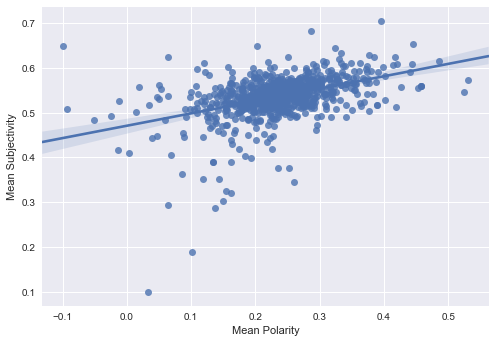

In [10]:
# Makes a scatter plot for each business category by average polarity and subjectivity by business category

mean_by_business = review.groupby('business_id').mean()

mean_sentiment_by_categories = categories.merge(mean_by_business[['polarity', 'subjectivity', 'stars']], right_index = True, left_on = categories.business_id)

polarity_averages = []
subjectivity_averages = []
stars_averages = [] 

for category in categories_master_list: 
    polarity_averages.append(mean_sentiment_by_categories[mean_sentiment_by_categories[category] == 1].mean()['polarity'])
    subjectivity_averages.append(mean_sentiment_by_categories[mean_sentiment_by_categories[category] == 1].mean()['subjectivity'])
    stars_averages.append(mean_sentiment_by_categories[mean_sentiment_by_categories[category] == 1].mean()['stars'])
    
categories_sentiment = pd.DataFrame({'Business Categories': categories_master_list, 'Mean Polarity': polarity_averages, 'Mean Subjectivity': subjectivity_averages, 'Mean Star Rating': stars_averages})

sns.regplot(y="Mean Subjectivity", x="Mean Polarity", data=categories_sentiment)
sns.plt.show()

There is clear clumping for various business categories in both graphs. Because of the sheer magnitude of business categories, understanding trends in each individual category would be tedious and not worth the effort. Several outliers exist, which warrant further analysis. In later analyses, I will focus on certain types of businesses (such as restaurants) and thus analyze the business categories within that general macro-category (such as fast food, style of restaurant, etc.). Comparing every business category with each other, other than through these two cursory graphs, is not necessarily helpful given wide range of types. For example, what would a fast food chain have in common with a beauty parlor or an amusement park? 

## Location 

To what extent does location people's measured favorability? Are people in certain areas either generally more likely to positively review and rate businesses and more critical in others? Cultural factors could influence either general population preferences or users' willingness to publically express their praise or criticism. 

Below I assess whether location may be a confounding variable for favorability. This is an initial exploration into how location may influence users stated experiences with the immediate goal of assessing whether location is a likely intermediary variable. Using the mean polarity of each business, I grouped the businesses by U.S. states and districts internationally to see whether there was a significant variation in polarity across different states. Later, I will use cluster analysis to create a fuller account of the influence of location in businesses. 


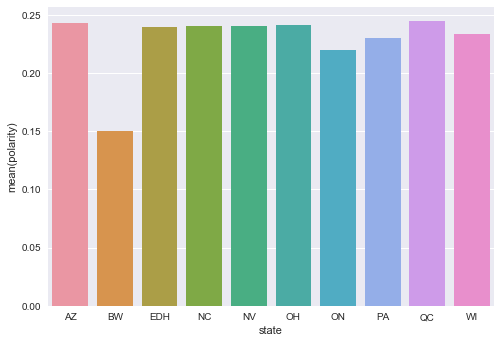

In [11]:
# Graphs the mean polarity by state. Only includes in the graph, states with at least 200 people 

threshhold_n = 100 

sentiment_by_location = review[['business_id', 'polarity', 'subjectivity']].merge(business[['business_id', 'city', 'state', 'latitude', 'longitude']])

mean_sentiment_by_state = sentiment_by_location.groupby('state').mean()
mean_sentiment_by_state['n'] = business['state'].value_counts()

sns.barplot(y=mean_sentiment_by_state[ mean_sentiment_by_state['n'] >= threshhold_n ].polarity, x=mean_sentiment_by_state[ mean_sentiment_by_state['n'] >= threshhold_n ].index)
sns.plt.show()

I now performed an f-test to confirm whether state has an influence on polarity. To maintain the requirements of an F-test, I only sampled states with comparitively large number of businesses (at least 500). 

In [12]:
# Conducts an F-test to determine whether state influences polarity. 

print('Null Hypothesis: All states would have (roughly) the same mean polarity in the sample population.')
print(' ')
print('Alternative Hypothesis: One or more states has a different mean polarity population.')
print(' ')

# Creates subcategory for each state that is sufficiently large. 
AZ = sentiment_by_location[sentiment_by_location['state'] == 'AZ']['polarity']
NV = sentiment_by_location[sentiment_by_location['state'] == 'NV']['polarity']
ON = sentiment_by_location[sentiment_by_location['state'] == 'ON']['polarity']
NC = sentiment_by_location[sentiment_by_location['state'] == 'NC']['polarity']
OH = sentiment_by_location[sentiment_by_location['state'] == 'OH']['polarity']
PA = sentiment_by_location[sentiment_by_location['state'] == 'PA']['polarity']
QC = sentiment_by_location[sentiment_by_location['state'] == 'QC']['polarity']
WI = sentiment_by_location[sentiment_by_location['state'] == 'WI']['polarity']
EDH = sentiment_by_location[sentiment_by_location['state'] == 'EDH']['polarity']
BW = sentiment_by_location[sentiment_by_location['state'] == 'BW']['polarity']
IL = sentiment_by_location[sentiment_by_location['state'] == 'IL']['polarity']
SC = sentiment_by_location[sentiment_by_location['state'] == 'SC']['polarity']

f,p = stats.f_oneway(AZ, NV, ON, NC, OH, PA, QC, WI, EDH, BW, IL)

print("F = " + str(f))
print('p = ' + str(p))

if(p_value < alpha): 
    print("Reject the null")
else: 
    print("Fail to reject the null")

Null Hypothesis: All states would have (roughly) the same mean polarity in the sample population.
 
Alternative Hypothesis: One or more states has a different mean polarity population.
 
F = 42.6245653722
p = 3.10526574261e-85
Reject the null


We can safely conclude that state (and thus location) likely influences polarity. I will use cluster analysis later to further analyze connections between locations and business populatarity among stores in the same locality. 

## Time of Year

Does favorability change over the course over the course of the year? During certain months of the year, are people more likely to appreciate a business and less likey to apprecriate during others? Seasonal differences can clearly influence people's mood and general disposition.

Below I assess whether the time of year may be a confounding variable for favorability. This is an initial exploration into possible influences conducted in order to determine whether month is a likely intermediary variable. I grouped each review by the month it was written and found the mean polarity for each month. 

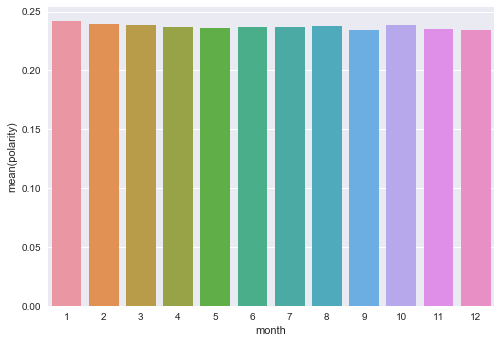

In [13]:
# Graphs the mean polarity by month. Only includes in the graph, states with at least 200 people 

review['month'] = pd.to_numeric(review.date.str.slice(5, 7))

mean_sentiment_by_month = review.groupby('month').mean()
mean_sentiment_by_month['n'] = review['month'].value_counts()


sns.barplot(y=mean_sentiment_by_month[ mean_sentiment_by_month['n'] >= threshhold_n ].polarity, x=mean_sentiment_by_month[ mean_sentiment_by_month['n'] >= threshhold_n ].index)
sns.plt.show()

I now performed an F-test to confirm whether month has an influence on polarity: 

In [15]:
# Conducts an F-test to determine whether month influences polarity. 

print('Null Hypothesis: All months would have (roughly) the same mean polarity in the sample population.')
print(' ')
print('Alternative Hypothesis: One or more months has a different mean polarity population.')
print(' ')

# Creates subcategory for each larger month. 
m1 = review[review['month'] == 1]['polarity']
m2 = review[review['month'] == 2]['polarity']
m3 = review[review['month'] == 3]['polarity']
m4 = review[review['month'] == 4]['polarity']
m5 = review[review['month'] == 5]['polarity']
m6 = review[review['month'] == 6]['polarity']
m7 = review[review['month'] == 7]['polarity']
m8 = review[review['month'] == 8]['polarity']
m9 = review[review['month'] == 9]['polarity']
m10 = review[review['month'] == 10]['polarity']
m11 = review[review['month'] == 11]['polarity']
m12 = review[review['month'] == 12]['polarity']


f,p_value = stats.f_oneway(m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12)

print("F = " + str(f))
print('p = ' + str(p_value))

if(p_value < alpha): 
    print("Reject the null")
else: 
    print("Fail to reject the null")

Null Hypothesis: All months would have (roughly) the same mean polarity in the sample population.
 
Alternative Hypothesis: One or more months has a different mean polarity population.
 
F = 1.55967245127
p = 0.103345068782
Fail to reject the null


The p-value is not that small, which means it is not likely that the month influences polarity. 

# Conclusion 

I have cleaned up the data, demonstrated why I intend to use polarity to analyze user favorabiity, and analyzed potential influencing variables. Subjectivity, which connects to the concept of polarity, and star rating, which also measures user preferences are clearly statistically related to polarity. Location (or at least state) is probably not related to polarity, but time of year likely is not. 

Next steps: 

1) Conduct cluster on how businesses and user favorability to group businesses based on common users

2) Analyze outliers in among favorability of certain types of businesses

3) Conduct cluser analysis on business locations to find localities and characterize potential local features 